In [1]:
import os
import pandas as pd
from pandas import DataFrame
from keras.models import Sequential, Model, Sequential, load_model, Input
from keras.layers import Dense, Input, Activation, Conv2D, MaxPool2D, Flatten, UpSampling2D, Conv2DTranspose, Reshape, LeakyReLU, Concatenate
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.utils import np_utils, plot_model
from keras import backend as K
import matplotlib.pyplot as plt
# matplotlib.use("TkAgg")
%matplotlib inline
import numpy as np
np.random.seed(1)
from PIL import Image
import random
import math
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
if not os.path.exists('model/'):
    os.makedirs('model/')

In [3]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
digit_size = 28
channels = 1
print('x_train\n', X_train.shape)
print('y_train\n', y_train.shape, y_train[0])
print('x_test\n', X_test.shape)
print('y_test\n', y_test.shape)

x_train
 (60000, 28, 28)
y_train
 (60000,) 5
x_test
 (10000, 28, 28)
y_test
 (10000,)


In [4]:
# data pre-processing
X_train = X_train.astype('float32') / 255       # minmax_normalized
X_test = X_test.astype('float32') / 255         # minmax_normalized
X_train = X_train.reshape((-1, digit_size, digit_size, channels))
X_test = X_test.reshape((-1, digit_size, digit_size, channels))
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


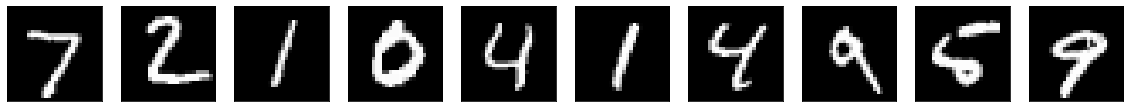

In [5]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    if channels > 1:
        plt.imshow(X_train[i].reshape(digit_size, digit_size, channels), cmap='binary')
    else:
        plt.imshow(X_test[i].reshape(digit_size, digit_size))
        plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [6]:
input_img = Input(shape=(digit_size, digit_size, channels))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPool2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = MaxPool2D((2, 2), padding='same')(x)

input_ec = Input(shape=(4, 4, 16)) 
x = Conv2D(16, (3, 3), padding='same')(input_ec)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(channels, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation('sigmoid')(x)

encoder = Model(inputs=input_img, outputs=encoded)
decoder = Model(input_ec, decoded)

del encoder
encoder = load_model('model/mnist_encoder.h5')
del decoder
decoder = load_model('model/mnist_decoder.h5')

ec = encoder(input_img)
dc = decoder(ec)
autoencoder = Model(input_img, dc)

autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')

encoder.summary()
decoder.summary()
autoencoder.summary()

W0709 10:49:17.617478 4813092288 deprecation_wrapper.py:119] From /Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0709 10:49:17.632875 4813092288 deprecation_wrapper.py:119] From /Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 10:49:17.635964 4813092288 deprecation_wrapper.py:119] From /Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 10:49:17.659901 4813092288 deprecation_wrapper.py:119] From /Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is de

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
__________

In [7]:
# training
autoencoder.fit(X_train, X_train, epochs=10, batch_size=256, shuffle=True)

encoder.save('model/mnist_encoder.h5')
decoder.save('model/mnist_decoder.h5')

Epoch 1/10
60000/60000 [==============================] - 137s 2ms/step - loss: 0.4989
Epoch 2/10
60000/60000 [==============================] - 134s 2ms/step - loss: 0.3851
Epoch 3/10
60000/60000 [==============================] - 137s 2ms/step - loss: 0.3173
Epoch 4/10
60000/60000 [==============================] - 137s 2ms/step - loss: 0.2684
Epoch 5/10
60000/60000 [==============================] - 133s 2ms/step - loss: 0.2320
Epoch 6/10
60000/60000 [==============================] - 132s 2ms/step - loss: 0.2041
Epoch 7/10
60000/60000 [==============================] - 132s 2ms/step - loss: 0.1826
Epoch 8/10
60000/60000 [==============================] - 132s 2ms/step - loss: 0.1656
Epoch 9/10
60000/60000 [==============================] - 132s 2ms/step - loss: 0.1518
Epoch 10/10
60000/60000 [==============================] - 132s 2ms/step - loss: 0.1406


(10, 28, 28, 1)


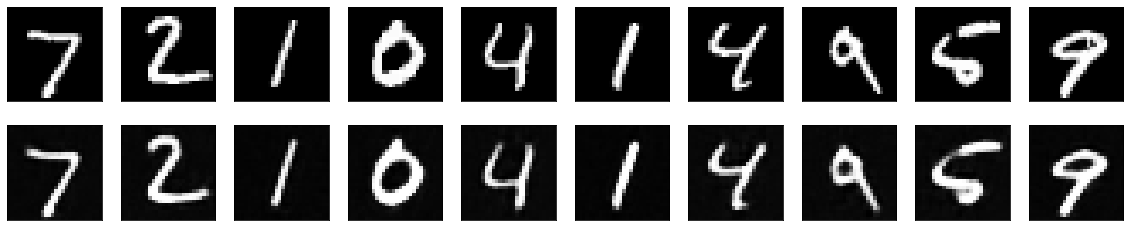

In [8]:
n = 10
decoded_imgs = autoencoder.predict(X_test[:n])
print(decoded_imgs.shape)
  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    if channels > 1:
        plt.imshow(X_test[i].reshape(digit_size, digit_size, channels), cmap='binary')
    else:
        plt.imshow(X_test[i].reshape(digit_size, digit_size))
        plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    if channels > 1:
        plt.imshow(decoded_imgs[i].reshape(digit_size, digit_size, channels), cmap='binary')
    else:
        plt.imshow(decoded_imgs[i].reshape(digit_size, digit_size))
        plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

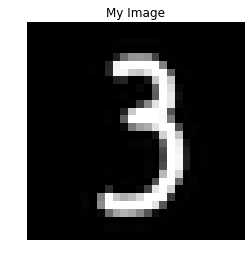

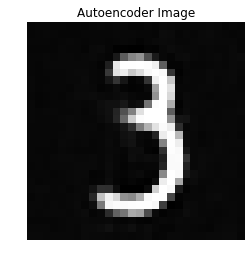

In [10]:
from PIL import Image
im = Image.open("./media/n_3.png")
if channels == 1:
    im = im.convert('L') # 轉成灰階
im = im.resize((digit_size, digit_size), Image.ANTIALIAS)
im = np.array(im) #convert to an array
im2 = im.astype('float32') / 255 # normalise input
# 畫圖
plt.imshow(im2, cmap='gray')
plt.title('My Image')
plt.axis('off')
plt.show()

test_image = np.reshape(im2, [1, digit_size, digit_size, channels]) # reshape it to our input placeholder shape
d_ = autoencoder.predict(test_image)
# 畫圖
if channels > 1:
    plt.imshow(np.reshape(d_, (digit_size, digit_size, channels)))
else:
    plt.imshow(np.reshape(d_, (digit_size, digit_size)))
plt.title('Autoencoder Image')
plt.axis('off')
plt.show()